Welcome to CPSC 4850/5850 Programming Assignment for Unit 4!

Before you do anything above it is very important that you run the following block (CPSC4850/5850 Framework Code).  

**DO NOT CHANGE ANYTHING IN THE FRAMEWORK CODE BLOCK**

# CPSC4850/5850 Framework Code

## Imports

In [ ]:
import cv2
import numpy as np
import copy
import math
import time
import PIL
import sklearn
from google.colab.patches import cv2_imshow
from google.colab import output
from IPython.display import Image
from itertools import combinations

## Generic Image utils

In [ ]:
def load_image(filename, scale=1.0):
  return scale_image(cv2.imread(filename), scale)

def scale_image(img, scale):
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def show_image(img, scale=1.0):
  if not scale == 1.0:
    cv2_imshow(scale_image(img, scale))
  else:
    cv2_imshow(img)

def world_height_and_width(img):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])
  world_height = 1.0
  world_width = pixel_width / pixel_height

  return (world_height, world_width)

def query_image(img, y_world, x_world, interpolate=True):
  if interpolate:
    return interpolate_image_value(img, y_world, x_world)
  else:
    i = world_space_to_image_space(img, y_world, x_world)
    return img[i[0], i[1], :]

# note: both image space and world space have origin in upper left corner of image
def image_space_to_world_space(img, y, x, clamp=False):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])
  world_height = 1.0
  world_width = pixel_width / pixel_height

  world_space_y = y / pixel_height
  if clamp:
    world_space_y = min(1.0, max(world_space_y, 0.0))

  world_space_x = (x / pixel_width) * world_width
  if clamp:
    world_space_x = min(1.0, max(world_space_x, 0.0))

  return (world_space_y, world_space_x)

def image_space_to_world_space_scalar(img, scalar):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])

  return scalar / pixel_height

# note: both image space and world space have origin in upper left corner of image
def world_space_to_image_space(img, y, x, clamp=False):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])
  world_height = 1.0
  world_width = pixel_width / pixel_height

  image_space_y = round(pixel_height * y)
  if clamp:
    image_space_y = max(0, min(image_space_y, pixel_height-1))
  image_space_x = round((pixel_width * x) / world_width)
  if clamp:
    image_space_x = max(0, min(image_space_x, pixel_width-1))

  return (image_space_y, image_space_x)

# note: both image space and world space have origin in upper left corner of image
def world_space_to_image_space_nonrounded(img, y, x):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])
  world_height = 1.0
  world_width = pixel_width / pixel_height

  image_space_y = pixel_height * y
  image_space_x = (pixel_width * x) / world_width

  return (image_space_y, image_space_x)

def world_space_to_image_space_scalar(img, scalar):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])

  return round(pixel_height * scalar)

def interpolate_image_value(img, y, x):
  shape = img.shape
  (pixel_height, pixel_width) = (shape[0], shape[1])
  world_height = 1.0
  world_width = pixel_width / pixel_height

  lower_bound_y = min(max(math.floor(pixel_height * y), 0), pixel_height-1)
  upper_bound_y = min(max(math.ceil(pixel_height * y), 0), pixel_height-1)
  lower_bound_x = min(max(math.floor((pixel_width * x)/ world_width), 0), pixel_width-1)
  upper_bound_x = min(max(math.ceil((pixel_width * x)/ world_width), 0), pixel_width-1)

  if lower_bound_y == upper_bound_y:
    if lower_bound_y == 0:
      upper_bound_y += 1
    elif upper_bound_y == pixel_height - 1:
      lower_bound_y -= 1
    else:
      upper_bound_y += 1

  if lower_bound_x == upper_bound_x:
    if lower_bound_x == 0:
      upper_bound_x += 1
    elif upper_bound_x == pixel_width - 1:
      lower_bound_x -= 1
    else:
      upper_bound_x += 1

  image_space_pt = world_space_to_image_space_nonrounded(img, y, x)
  lower_left = [lower_bound_y, lower_bound_x]
  upper_left = [upper_bound_y, lower_bound_x]
  lower_right = [lower_bound_y, upper_bound_x]
  upper_right = [upper_bound_y, upper_bound_x]
  pt = [image_space_pt[0], image_space_pt[1]]

  q = quadratic_barycentric_coordinates(pt, lower_left, upper_left, upper_right, lower_right)

  ret = q[0]*img[lower_bound_y, lower_bound_x, :] + \
        q[1]*img[upper_bound_y, lower_bound_x, :] + \
        q[2]*img[upper_bound_y, upper_bound_x, :] + \
        q[3]*img[lower_bound_y, upper_bound_x, :]

  return ret

def quadratic_barycentric_coordinates(pt, v1, v2, v3, v4):
  pt = np.array(pt)
  v1 = np.array(v1)
  v2 = np.array(v2)
  v3 = np.array(v3)
  v4 = np.array(v4)

  a = v1 - pt
  b = v2 - v1
  c = v4 - v1
  d = v1 - v2 - v4 + v3

  a3 = np.array([a[0], a[1], 0.0])
  b3 = np.array([b[0], b[1], 0.0])
  c3 = np.array([c[0], c[1], 0.0])
  d3 = np.array([d[0], d[1], 0.0])

  a_cross = np.cross(c3, d3)
  b_cross = np.cross(c3, b3) + np.cross(a3, d3)
  c_cross = np.cross(a3, b3)

  aa = a_cross[2]
  bb = b_cross[2]
  cc = c_cross[2]

  u1 = 0.0
  u2 = 0.0

  if abs(aa) < 0.00000000000001:
    u1 = -cc / bb
    u2 = u1
  else:
    if bb*bb - 4.0 * aa * cc > 0.0:
      u1 = (-bb + math.sqrt(bb*bb - 4.0*aa*cc)) / 2.0*aa
      u2 = (-bb - math.sqrt(bb*bb - 4.0*aa*cc)) / 2.0*aa
    else:
      u1 = -1000.0
      u2 = u1

  mu = -100000.0
  if u1 >= 0.0 and u1 <= 1.0:
    mu = u1
  if u2 >= 0.0 and u2 <= 1.0:
    mu = u2

  a_cross = np.cross(b3, d3)
  b_cross = np.cross(b3, c3) + np.cross(a3, d3)
  c_cross = np.cross(a3, c3)

  aa = a_cross[2]
  bb = b_cross[2]
  cc = c_cross[2]

  w1 = 0.0
  w2 = 0.0

  if abs(aa) < 0.00000000000001:
    w1 = -cc / bb
    w2 = w1
  else:
    if bb*bb - 4.0 * aa * cc > 0.0:
      w1 = (-bb + math.sqrt(bb*bb - 4.0*aa*cc)) / 2.0*aa
      w2 = (-bb - math.sqrt(bb*bb - 4.0*aa*cc)) / 2.0*aa
    else:
      w1 = -1000.0
      w2 = w1

  la = -10000.0
  if w1 >= 0.0 and w1 <= 1.0:
    la = w1
  if w2 >= 0.0 and w2 <= 1.0:
    la = w2

  alpha1 = (1.0-mu)*(1.0-la)
  alpha2 = la*(1.0-mu)
  alpha3 = mu * la
  alpha4 = (1.0-la)*mu

  return (alpha1, alpha2, alpha3, alpha4)

## Planning Image utils

In [ ]:
def is_point_in_collision(img, y_world, x_world):
  [y, x] = world_space_to_image_space(img, y_world, x_world, clamp=True)
  [b, g, r] = img[y,x]
  grayscale = 0.299*r + 0.587*g + 0.114*b
  if grayscale < 100.0:
    return True
  else:
    return False

## Drawing utils

In [ ]:
def draw_transparent_rectangle(img, alpha, y_world, x_world, h_world, w_world, bgr_color, thickness_world=-1):
  overlay = img.copy()
  thickness = world_space_to_image_space_scalar(img, thickness_world)
  (y, x) = world_space_to_image_space(img, y_world, x_world)
  (yd, xd) = world_space_to_image_space(img, y_world + h_world, x_world + w_world)
  cv2.rectangle(overlay, [x,y], [xd,yd], bgr_color, thickness)

  new_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
  return new_img

def draw_transparent_rectangle_from_center(img, alpha, y_center_world, x_center_world, h_world, w_world, bgr_color, thickness_world=-1):
  y_world = y_center_world - (h_world / 2.0)
  x_world = x_center_world - (w_world / 2.0)
  return draw_transparent_rectangle(img, alpha, y_world, x_world, h_world, w_world, bgr_color, thickness_world)

def erase_transparent_rectangle(img, original_img, y_world, x_world, h_world, w_world, thickness_world=-1):
  shape = img.shape
  h = shape[0]
  w = shape[1]
  alpha_img = np.zeros((shape[0], shape[1], 3), dtype = np.uint8)
  thickness = world_space_to_image_space_scalar(alpha_img, thickness_world)
  (y, x) = world_space_to_image_space(alpha_img, y_world, x_world)
  (yd, xd) = world_space_to_image_space(alpha_img, y_world + h_world, x_world + w_world)
  img[y:yd+1, x:xd+1, :] = original_img[y:yd+1, x:xd+1, :]

def erase_transparent_rectangle_from_center(img, original_img, y_center_world, x_center_world, h_world, w_world, thickness_world=-1):
  y_world = y_center_world - (h_world / 2.0)
  x_world = x_center_world - (w_world / 2.0)
  erase_transparent_rectangle(img, original_img, y_world, x_world, h_world, w_world, thickness_world)

def draw_transparent_circle(img, alpha, y_center_world, x_center_world, r_world, bgr_color, thickness_world=-1):
  overlay = img.copy()
  r = world_space_to_image_space_scalar(img, r_world)
  thickness = world_space_to_image_space_scalar(img, thickness_world)
  (y, x) = world_space_to_image_space(img, y_center_world, x_center_world)
  cv2.circle(overlay, [x,y], r, bgr_color, thickness)

  new_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
  return new_img

def draw_transparent_line(img, alpha, y_world_1, x_world_1, y_world_2, x_world_2, bgr_color, thickness_world=0.001):
  overlay = img.copy()
  thickness = max(world_space_to_image_space_scalar(img, thickness_world), 1)
  (y1, x1) = world_space_to_image_space(img, y_world_1, x_world_1)
  (y2, x2) = world_space_to_image_space(img, y_world_2, x_world_2)

  cv2.line(overlay, [x1, y1], [x2, y2], bgr_color, thickness)

  new_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
  return new_img

## GIF utils

In [ ]:
def output_gif_from_cv2_imgs(imgs, output_name, fps=30, num_seconds_at_end=1):
  if len(imgs) == 0:
    print('could not output {}.gif because the image stack was empty.'.format(output_name))
    return

  stride = 1
  if fps > 30:
    stride = round(fps / 30)
  image_imgs = []
  for img in imgs[0::stride]:
    ii = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_imgs.append(PIL.Image.fromarray(ii))
  if fps > 30:
    ii = cv2.cvtColor(imgs[-1], cv2.COLOR_BGR2RGB)
    image_imgs.append(PIL.Image.fromarray(ii))
  duration = (1.0/(min(30, fps)))*1000.0
  duration_sum = 0.0
  while duration_sum < num_seconds_at_end*1000.0:
    ii = cv2.cvtColor(imgs[-1], cv2.COLOR_BGR2RGB)
    image_imgs.append(PIL.Image.fromarray(ii))
    duration_sum += duration

  frame_one = image_imgs[0]
  frame_one.save('{}.gif'.format(output_name), format="GIF", append_images=image_imgs, save_all=True, duration=duration, loop=0)
  print('{}.gif has been created.  Click on the file in the files sidebar for playback.'.format(output_name))

## Geometry utils

In [ ]:
def bresenham(y0, x0, y1, x1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
      xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
      dx, dy = dy, dx
      xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
      yield x0 + x*xx + y*yx, y0 + x*xy + y*yy
      if D >= 0:
        y += 1
        D -= 2*dx
      D += 2*dy

## Grid Planner util


In [ ]:
class GridPlannerUtil:
  def __init__(self, filename, cell_width=0.04, scale=1.0):
    self.raw_img = load_image(filename, scale=scale)
    self.draw_img = self.raw_img.copy()
    self.cell_width = cell_width
    self.gif_image_stack = [ ]

    cell_half_width = cell_width / 2
    (h, w) = world_height_and_width(self.raw_img)

    cell_x_values = []
    cell_y_values = []

    curr_x_value = cell_half_width
    while curr_x_value <= w:
      cell_x_values.append(curr_x_value)
      curr_x_value += cell_width

    curr_y_value = cell_half_width
    while curr_y_value <= h:
      cell_y_values.append(curr_y_value)
      curr_y_value += cell_width

    self.cell_centers = [ ]

    for (idx, y_value) in enumerate(cell_y_values):
      self.cell_centers.append([])
      for x_value in cell_x_values:
        self.cell_centers[idx].append( (y_value, x_value) )
        self.draw_img = draw_transparent_rectangle_from_center(self.draw_img, 0.2, y_value, x_value, cell_width, cell_width, (70, 70, 70), 0.001)

    self.num_rows = len(self.cell_centers)
    self.num_cols = len(self.cell_centers[0])

    self.original_img = self.draw_img.copy()
    self.save_image_to_gif_image_stack()

    self.visited = np.zeros((self.num_rows, self.num_cols))
    # self.grid_colors = self.num_rows*[self.num_cols*[ [ ] ]]
    self.grid_colors = [ ]
    for _ in range(self.num_rows):
      a = [ ]
      for _ in range(self.num_cols):
        a.append([])
      self.grid_colors.append(a)

  def is_cell_in_collision(self, coords):
    if coords[0] < 0 or coords[0] >= self.num_rows:
      return True
    if coords[1] < 0 or coords[1] >= self.num_cols:
      return True

    cell_center = self.cell_centers[coords[0]][coords[1]]
    a = self.cell_width / 2
    corner1 = [cell_center[0]-a, cell_center[1]-a]
    corner2 = [cell_center[0]-a, cell_center[1]+a]
    corner3 = [cell_center[0]+a, cell_center[1]-a]
    corner4 = [cell_center[0]+a, cell_center[1]+a]
    points = [cell_center, corner1, corner2, corner3, corner4]

    for p in points:
      if is_point_in_collision(self.original_img, p[0], p[1]):
        return True

    return False

  def mark_cell_as_visited(self, coords):
    self.visited[coords[0]][coords[1]] = 1

  def mark_cell_as_unvisited(self, coords):
    self.visited[coords[0]][coords[1]] = 0

  def has_cell_been_visited(self, coords):
    if coords[0] < 0 or coords[0] >= self.num_rows:
      return True
    if coords[1] < 0 or coords[1] >= self.num_cols:
      return True

    return self.visited[coords[0]][coords[1]] == 1

  def color_in_cell(self, coords, bgr_color, alpha=0.7):
    if coords[0] < 0 or coords[1] < 0: return
    cell_center = self.cell_centers[coords[0]][coords[1]]
    erase_transparent_rectangle_from_center(self.draw_img, self.original_img, cell_center[0], cell_center[1], self.cell_width*0.99, self.cell_width*0.99)
    self.grid_colors[coords[0]][coords[1]].append( (bgr_color, alpha) )
    self.draw_img = draw_transparent_rectangle_from_center(self.draw_img, alpha, cell_center[0], cell_center[1], self.cell_width*0.99, self.cell_width*0.99, bgr_color)

  def erase_color_from_cell(self, coords):
    if coords[0] < 0 or coords[1] < 0: return
    cell_center = self.cell_centers[coords[0]][coords[1]]
    erase_transparent_rectangle_from_center(self.draw_img, self.original_img, cell_center[0], cell_center[1], self.cell_width*0.99, self.cell_width*0.99)
    coord_colors = self.grid_colors[coords[0]][coords[1]]
    if not len(coord_colors) == 0:
      p = coord_colors.pop()
      if not len(coord_colors) == 0:
        p = coord_colors.pop()
        self.color_in_cell(coords, p[0], alpha=p[1])

  def show_image(self, scale=1.0):
    show_image(self.draw_img, scale=scale)

  def get_closest_cell_to_world_coordinates(self, y_world, x_world):
    closest_cells = [0,0]
    closest_distance = 999999999999.9

    for i in range(self.num_rows):
      for j in range(self.num_cols):
        cell_center = self.cell_centers[i][j]
        dis = math.sqrt((cell_center[0] - y_world)**2 + (cell_center[1] - x_world)**2)
        if dis < closest_distance:
          closest_distance = dis
          closest_cells = [i,j]

    return closest_cells

  def save_image_to_gif_image_stack(self):
    self.gif_image_stack.append(self.draw_img.copy())

  def output_gif_animation(self, output_name, fps=30, num_seconds_at_end=1):
    output_gif_from_cv2_imgs(self.gif_image_stack, output_name, fps, num_seconds_at_end)

## Continuous Planner util

In [ ]:
class ContinuousPlannerUtil:
  def __init__(self, filename, scale=1.0):
    self.raw_img = load_image(filename, scale=scale)
    self.draw_img = self.raw_img.copy()
    (self.height, self.width) = world_height_and_width(self.raw_img)
    self.gif_image_stack = []

  def sample_state(self):
    return np.array([np.random.uniform(high=self.height), np.random.uniform(high=self.width)])

  def is_state_in_collision(self, state):
    if state[0] < 0.0 or state[0] > self.height or state[1] < 0.0 or state[1] > self.width:
      return True
    else:
      return is_point_in_collision(self.raw_img, state[0], state[1])

  def is_straight_line_connection_feasible(self, state_1, state_2, step_size = 0.01):
    state_1_arr = np.array(state_1)
    state_2_arr = np.array(state_2)
    dis = np.linalg.norm( state_1_arr - state_2_arr )
    aa = np.linspace(0.0, 1.0, math.ceil(dis / step_size))
    if len(aa) < 2:
      aa = [0.0, 1.0]
    for a in aa:
      s = (1.0 - a)*state_1_arr + a*state_2_arr
      if self.is_state_in_collision(s):
        return False
    return True

  def draw_vertices_and_edges(self, vertex_list, edge_list, clear_draw_img=True):
    if clear_draw_img:
      self.clear_draw_img()
    overlay = self.draw_img.copy()

    line_thickness_world = 0.001
    line_thickness = max(world_space_to_image_space_scalar(self.draw_img, line_thickness_world), 1)
    r_world = 0.006
    r = world_space_to_image_space_scalar(self.draw_img, r_world)
    alpha1 = 0.6
    alpha2 = 0.9
    # line_color = (30,30,30)
    # circle_color = (255,200,30)

    for edge in edge_list.edges:
      v1 = edge.vertex_1
      v2 = edge.vertex_2

      (y1, x1) = world_space_to_image_space(self.draw_img, v1.state[0], v1.state[1])
      (y2, x2) = world_space_to_image_space(self.draw_img, v2.state[0], v2.state[1])

      cv2.line(overlay, [x1, y1], [x2, y2], edge.bgr_color, line_thickness)

    self.draw_img = cv2.addWeighted(overlay, alpha1, self.draw_img, 1 - alpha1, 0)

    overlay = self.draw_img.copy()
    for v in vertex_list.vertices:
        (y, x) = world_space_to_image_space(self.draw_img, v.state[0], v.state[1])

        cv2.circle(overlay, [x,y], r, v.bgr_color, -1)

    self.draw_img = cv2.addWeighted(overlay, alpha2, self.draw_img, 1 - alpha2, 0)


  def draw_circle(self, coords, radius, bgr_color, alpha=0.7, thickness=-1):
    self.draw_img = draw_transparent_circle(self.draw_img, alpha, coords[0], coords[1], radius, bgr_color, thickness)

  def draw_line_segment(self, coords1, coords2, thickness, bgr_color, alpha=0.7):
    self.draw_img = draw_transparent_line(self.draw_img, alpha, coords1[0], coords1[1], coords2[0], coords2[1], bgr_color, thickness)

  def clear_draw_img(self):
    self.draw_img = self.raw_img.copy()

  def show_image(self, scale=1.0):
    show_image(self.draw_img, scale=scale)

  def save_image_to_gif_image_stack(self):
    self.gif_image_stack.append(self.draw_img.copy())

  def output_gif_animation(self, output_name, fps=30, num_seconds_at_end=1):
    output_gif_from_cv2_imgs(self.gif_image_stack, output_name, fps, num_seconds_at_end)


## Continuous planning components

These components are NOT intended to be efficient!  They are just for educational purposes

In [ ]:
class Vertex:
  def __init__(self, state, bgr_color=(255,200,30)):
    self.state = np.array(state)
    self.outgoing_edges = [ ]
    self.incoming_edges = [ ]
    self.bgr_color = bgr_color

class Edge:
  def __init__(self, vertex_1, vertex_2, bgr_color=(30,30,30)):
    self.vertex_1 = vertex_1
    self.vertex_2 = vertex_2
    self.vertex_1.outgoing_edges.append(self)
    self.vertex_2.incoming_edges.append(self)
    self.length = np.linalg.norm( vertex_1.state - vertex_2.state )
    self.bgr_color = bgr_color

class VertexList:
  def __init__(self):
    self.vertices = [ ]

  def add_vertex(self, vertex):
    self.vertices.append(vertex)
    return vertex

  def get_graph_vertices_within_distance_r(self, state, r, sorted=True):
    output = [ ]
    for vertex in self.vertices:
      dis = np.linalg.norm(vertex.state - np.array(state))
      if dis < r:
        output.append( (vertex, dis) )

    if sorted:
      output.sort( key = lambda a: a[1] )

    return output

  def get_n_closest_vertices_in_graph_in_sorted_order(self, state, n):
    assert(n > 0)

    output = [ ]
    for vertex in self.vertices:
      dis = np.linalg.norm(vertex.state - np.array(state))
      output.append( (vertex, dis) )

    output.sort( key = lambda a: a[1] )
    return output[0:n]

  def get_closest_vertex_in_graph(self, state):
    closest_vertex = None
    closest_dis = float('inf')

    for vertex in self.vertices:
      dis = np.linalg.norm(vertex.state - np.array(state))
      if dis < closest_dis:
        closest_vertex = vertex
        closest_dis = dis

    return (closest_vertex, closest_dis)

class VertexListKDTree:
  def __init__(self, dim):
    self.vertices = [ ]
    self.kdtree = KDTree(dim)

  def add_vertex(self, vertex):
    idx = len(self.vertices)
    self.vertices.append(vertex)
    self.kdtree.insert( vertex.state, idx )
    return vertex

  def get_graph_vertices_within_distance_r(self, state, r):
    output = [ ]
    q = self.kdtree.radius_query(np.array(state), r)
    for (state, dis, idx) in q:
      output.append( (self.vertices[idx], dis) )

    return output

  def get_n_closest_vertices_in_graph_in_sorted_order(self, state, n):
    assert(n > 0)

    output = [ ]
    q = self.kdtree.query(np.array(state), n)

    for (state, dis, idx) in q:
      output.append( (self.vertices[idx], dis) )

    return output

  def get_closest_vertex_in_graph(self, state):
    q = self.kdtree.query(np.array(state), 1)
    (state, dis, idx) = q[0]

    return (self.vertices[idx], dis)

class EdgeList:
  def __init__(self):
    self.edges = [ ]

  def add_edge(self, edge):
    self.edges.append(edge)
    return edge

  def delete_edge(self, vertex_1, vertex_2):
    edges_to_delete = []
    for edge in self.edges:
      if edge.vertex_1 == vertex_1 and edge.vertex_2 == vertex_2:
        edge.vertex_1.outgoing_edges.remove(edge)
        edge.vertex_2.incoming_edges.remove(edge)
        edges_to_delete.append(edge)
    for edge in edges_to_delete:
      self.edges.remove(edge)

## KDTree

In [ ]:
class Node:
    def __init__(self, point, idx, left=None, right=None):
        self.point = point
        self.idx = idx
        self.left = left
        self.right = right

class KDTree:
    def __init__(self, dim):
        self.root = None
        self.k = dim
        self.build(np.array([]))

    def build(self, points, depth=0):
        n = points.shape[0]
        if n <= 0:
            return None
        axis = depth % self.k
        sorted_points = points[points[:, axis].argsort()]
        median_idx = n // 2
        median = sorted_points[median_idx]
        left = self.build(sorted_points[:median_idx], depth+1)
        right = self.build(sorted_points[median_idx+1:], depth+1)
        return Node(median, left, right)

    def insert(self, point, idx):
        if self.root is None:
            self.root = Node(point, idx)
        else:
            self._insert(point, idx, self.root, 0)

    def _insert(self, point, idx, node, depth):
        if point[node.point.argmax()] > node.point[node.point.argmax()]:
            if node.right is None:
                node.right = Node(point, idx)
            else:
                self._insert(point, idx, node.right, depth+1)
        else:
            if node.left is None:
                node.left = Node(point, idx)
            else:
                self._insert(point, idx, node.left, depth+1)

    def query(self, point, k=1):
        neighbors = []
        self._query(point, self.root, k, neighbors, 0)
        return sorted(neighbors, key=lambda x: x[1])

    def _query(self, point, node, k, neighbors, depth):
        if node is None:
            return
        dist = np.linalg.norm(point - node.point)
        if len(neighbors) < k:
            neighbors.append((node.point, dist, node.idx))
        else:
            if dist < neighbors[-1][1]:
                neighbors.pop()
                neighbors.append((node.point, dist, node.idx))
        axis = depth % self.k
        if point[axis] < node.point[axis]:
            self._query(point, node.left, k, neighbors, depth+1)
        else:
            self._query(point, node.right, k, neighbors, depth+1)

    def radius_query(self, point, r):
        neighbors = []
        self._radius_query(point, self.root, r, neighbors, 0)
        return sorted(neighbors, key=lambda x: x[1])

    def _radius_query(self, point, node, r, neighbors, depth):
        if node is None:
            return
        dist = np.linalg.norm(point - node.point)
        if dist < r:
            neighbors.append((node.point, dist, node.idx))
        axis = depth % self.k
        if point[axis] - r < node.point[axis]:
            self._radius_query(point, node.left, r, neighbors, depth+1)
        if point[axis] + r > node.point[axis]:
            self._radius_query(point, node.right, r, neighbors, depth+1)

## Line Segment System

In [ ]:
class LineSegmentSystem:
  def __init__(self, base, links, joints, line_thickness=0.01, dot_radius=0.0):
    self.pixel_height = 360
    self.pixel_width = 640
    self.draw_img = np.zeros([self.pixel_height,self.pixel_width,3],dtype=np.uint8)
    np.pad(self.draw_img, pad_width=2, mode='constant', constant_values=0)
    self.draw_img.fill(255)
    (h, w) = world_height_and_width(self.draw_img)
    self.h = h
    self.w = w
    self.line_thickness = line_thickness
    self.dot_radius = dot_radius

    self.set_base_links_and_joints(base, links, joints)

    self.gif_image_stack = [ ]

  def set_base_links_and_joints(self, base, links, joints):
    self.base = base
    self.joints = joints
    self.links = links
    self.num_joints = len(joints)
    self.num_links = len(links)
    self.__set_num_dofs()

  def __set_num_dofs(self):
    self.num_dofs = 0
    self.num_dofs += self.base.num_dofs
    for j in self.joints:
      self.num_dofs += j.num_dofs

    self.bounds = self.num_dofs*[(-1,1)]

  def show_image(self, scale=1.0):
    show_image(self.draw_img, scale=scale)

  def clear_image(self):
    self.draw_img.fill(255)
    for i in range(self.pixel_height):
      self.draw_img[i,0,:] = 0
      self.draw_img[i,self.pixel_width-1,:] = 0

    for i in range(self.pixel_width):
      self.draw_img[0,i,:] = 0
      self.draw_img[self.pixel_height-1, i,:] = 0

  # assumes that joints are in hierarchical order
  def forward_kinematics(self, state):
    assert len(state) == self.num_dofs

    out = []
    for i in range(self.num_links):
      out.append(np.eye(3))

    curr_dof_idx = 0

    out[0][0][2] = self.base.x
    out[0][1][2] = self.base.y

    if self.base.mode == 'mobile':
      # reversed so that state[0] will be "y" and state[1] will be "x"
      out[0][1][2] += state[0]
      out[0][0][2] += state[1]
      curr_dof_idx += 2

    for j in self.joints:
      offset_frame = np.eye(3)
      variable_frame = np.eye(3)

      offset_frame[0][2] = j.length
      if j.mode == 'revolute':
        c = math.cos(state[curr_dof_idx])
        s = math.sin(state[curr_dof_idx])
        variable_frame[0][0] = c
        variable_frame[0][1] = -s
        variable_frame[1][0] = s
        variable_frame[1][1] = c
      elif j.mode == 'prismatic':
        variable_frame[0][2] = state[curr_dof_idx]

      curr_dof_idx += 1

      out[j.child_link_idx] = out[j.parent_link_idx]@variable_frame@offset_frame

    return out

  # will return points in y, x order, to make it easier to draw lines in cv
  def forward_kinematics_yx_points(self, state):
    fk_frames = self.forward_kinematics(state)
    out = []
    for fk_frame in fk_frames:
      out.append([fk_frame[1][2], fk_frame[0][2]])
    return out

  def get_all_link_segments(self, state):
    yx_points = self.forward_kinematics_yx_points(state)
    out = []
    for joint in self.joints:
      child_link_idx = joint.child_link_idx
      parent_link_idx = joint.parent_link_idx
      out.append( (yx_points[child_link_idx], yx_points[parent_link_idx]) )
    return out

  def is_state_in_collision(self, state, threshold=0.01):
    segments = self.get_all_link_segments(state)

    for segment in segments:
      p1 = segment[0]
      p2 = segment[1]
      if p1[0] < 0 or p1[0] > self.h or p1[1] < 0 or p1[1] > self.w:
        return True
      elif p2[0] < 0 or p2[0] > self.h or p2[1] < 0 or p2[1] > self.w:
        return True

    c = list(combinations(segments, r=2))
    for cc in c:
      c0 = cc[0]
      c1 = cc[1]
      (dis, connected) = closest_line_seg_line_seg(c0, c1)
      if dis < threshold and not connected:
        return True
    return False

  def sample_state(self):
    out_state = []
    for b in self.bounds:
      out_state.append(np.random.uniform(low=b[0], high=b[1]))
    return np.array(out_state)

  def sample_feasible_state(self):
    while True:
      s = self.sample_state()
      if not self.is_state_in_collision(s):
        return s

  def draw_state(self, state, clear_image=True):
    if clear_image:
      self.clear_image()

    yx_points = self.forward_kinematics_yx_points(state)

    num_points = len(yx_points)
    for joint in self.joints:
      child_link_idx = joint.child_link_idx
      parent_link_idx = joint.parent_link_idx
      thickness = world_space_to_image_space_scalar(self.draw_img, self.line_thickness)
      p1 = yx_points[child_link_idx]
      p2 = yx_points[parent_link_idx]
      (y1, x1) = world_space_to_image_space(self.draw_img, p1[0], p1[1])
      (y2, x2) = world_space_to_image_space(self.draw_img, p2[0], p2[1])
      cv2.line(self.draw_img, [x1, y1], [x2, y2], self.links[child_link_idx].bgr_color, thickness)

    for link_idx in range(num_points):
      radius = world_space_to_image_space_scalar(self.draw_img, self.dot_radius)
      thickness = world_space_to_image_space_scalar(self.draw_img, -1)
      p1 = yx_points[link_idx]
      (y, x) = world_space_to_image_space(self.draw_img, p1[0], p1[1])
      cv2.circle(self.draw_img, [x,y], radius, (0,0,0), thickness)

  def draw_circle(self, alpha, y_center_world, x_center_world, r_world, bgr_color, thickness_world=-1):
    self.draw_img = draw_transparent_circle(self.draw_img, alpha, y_center_world, x_center_world, r_world, bgr_color, thickness_world)

  def save_image_to_gif_image_stack(self):
    self.gif_image_stack.append(self.draw_img.copy())

  def output_gif_animation(self, output_name, fps=30, num_seconds_at_end=1):
    output_gif_from_cv2_imgs(self.gif_image_stack, output_name, fps, num_seconds_at_end)

# mode is mobile or static
class Base:
  def __init__(self, y, x, mode):
    self.y = y
    self.x = x
    self.mode = mode
    if mode == 'mobile':
      self.num_dofs = 2
    elif mode == 'static':
      self.num_dofs = 0
    else:
      assert False, 'mode is invalid'

class Link:
  def __init__(self, link_idx, bgr_color=(0,0,0)):
    self.link_idx = link_idx
    self.bgr_color = bgr_color

# modes are revolute and prismatic
class Joint:
  def __init__(self, length, mode, parent_link_idx, child_link_idx):
    self.length = length
    self.mode = mode
    if mode == 'revolute':
      self.num_dofs = 1
    elif mode == 'prismatic':
      self.num_dofs = 1
    else:
      assert False, 'mode is invalid'

    self.child_link_idx = child_link_idx
    self.parent_link_idx = parent_link_idx

def closest_line_seg_line_seg(seg1, seg2):
    p1 = np.array(seg1[0])
    p2 = np.array(seg1[1])
    p3 = np.array(seg2[0])
    p4 = np.array(seg2[1])

    P1 = p1
    P2 = p3
    V1 = p2 - p1
    V2 = p4 - p3
    V21 = P2 - P1

    v22 = np.dot(V2, V2)
    v11 = np.dot(V1, V1)
    v21 = np.dot(V2, V1)
    v21_1 = np.dot(V21, V1)
    v21_2 = np.dot(V21, V2)
    denom = v21 * v21 - v22 * v11

    if np.isclose(denom, 0.):
        s = 0.
        t = (v11 * s - v21_1) / v21
    else:
        s = (v21_2 * v21 - v22 * v21_1) / denom
        t = (-v21_1 * v21 + v11 * v21_2) / denom

    s = max(min(s, 1.), 0.)
    t = max(min(t, 1.), 0.)

    p_a = P1 + s * V1
    p_b = P2 + t * V2

    dis = np.linalg.norm(p_a-p_b)
    connected = False
    if np.isclose(dis, 0):
      if np.isclose(s, 0) or np.isclose(s, 1):
        if np.isclose(t, 0) or np.isclose(t, 1):
          connected = True

    return (dis, connected)


## Snake Robot

In [ ]:
class SnakeRobot(LineSegmentSystem):
  def __init__(self):
    base = Base(0.5, 0.02, 'mobile')
    links = []
    for i in range(33):
      links.append(Link(i, bgr_color=(255, 100, 0)))

    joints = []
    for i in range(32):
      joints.append(Joint(0.1, 'revolute', i, i+1))

    super().__init__(base, links, joints, line_thickness=0.015, dot_radius=0.01)

    for i in range(self.num_dofs):
      self.bounds[i] = (-3, 3)

    self.bounds[0] = (0, self.h)
    self.bounds[1] = (0, self.w)

## Robot Arm

In [ ]:
class RobotArm(LineSegmentSystem):
  def __init__(self):

    base = Base(0.98, 0.8888885, 'static')
    links = []
    for i in range(7):
      links.append(Link(i, bgr_color=(130, 100, 100)))

    joints = []
    joints.append(Joint(0.3, 'revolute', 0, 1))
    joints.append(Joint(0.2, 'revolute', 1, 2))
    joints.append(Joint(0.1, 'revolute', 2, 3))
    joints.append(Joint(0.1, 'revolute', 3, 4))
    joints.append(Joint(0.1, 'revolute', 4, 5))
    joints.append(Joint(0.05, 'revolute', 5, 6))

    super().__init__(base, links, joints, line_thickness=0.025, dot_radius=0.02)

    for i in range(self.num_dofs):
      self.bounds[i] = (-3, 3)

  def get_end_effector_position(self, state):
    yx_points = self.forward_kinematics_yx_points(state)
    return yx_points[-1]


## Finite Differencing

In [ ]:
def gradient_fd(f, x):
  num_variables = len(x)
  out = [ ]

  f_0 = f(x)
  delta_x = 0.0001

  for i in range(num_variables):
    x_copy = np.copy(x)
    x_copy[i] = x_copy[i] + delta_x
    f_delta = f(x_copy)
    out.append( (f_delta - f_0) / delta_x )

  return np.array(out)

def hessian_fd(f, x):
  num_variables = len(x)
  out = [ ]

  f_0 = gradient_fd(f, x)
  delta_x = 0.0001

  for i in range(num_variables):
    x_copy = np.copy(x)
    x_copy[i] = x_copy[i] + delta_x
    f_delta = gradient_fd(f, x_copy)
    out.append( (f_delta - f_0) / delta_x )

  return np.array(out)

# Assignment

## Preliminaries / Tutorial

After you run the framework code above, load the `circle.png` image into the Google Colab environment.  This can be done in the folder pop-up menu in the left panel.  

Run the following code to verify that you correctly loaded the image.

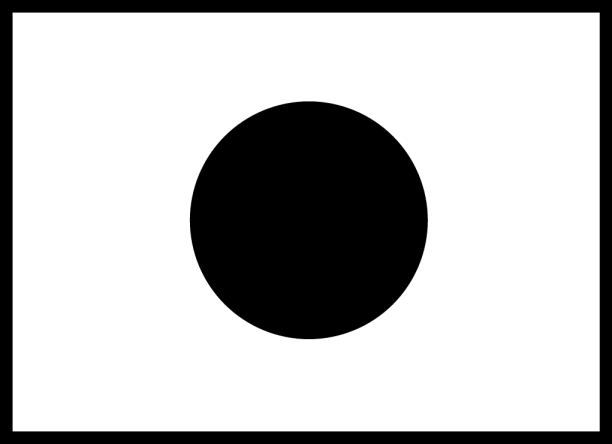

In [ ]:
img = load_image('circle.png', scale=0.6)
show_image(img)

Next, we will initialize a `ContinuousPlannerUtil` object with the `circle.png` image.

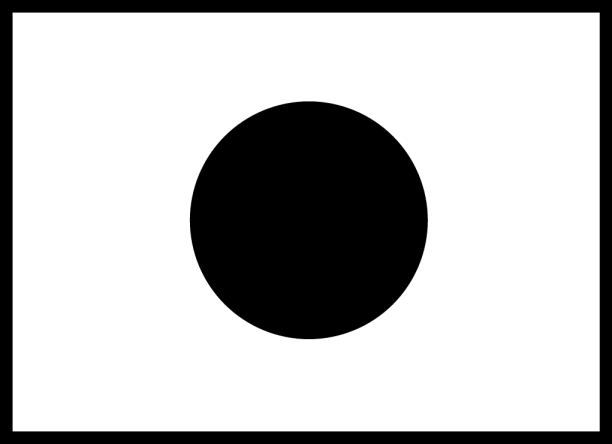

In [ ]:
c = ContinuousPlannerUtil('circle.png', scale=0.6)
c.show_image()

Note that the image is now a continuous "environment" with the [0,0] point in the upper left, and points situated in a (down, right) fashion.  

The lower right point on the image can be found as follows:


In [ ]:
lower_right_point = [c.height, c.width]
print(lower_right_point)

[1.0, 1.3783783783783783]


The height and width values here reflect the aspect ratio of the image (with height fixed at 1.0)

Our `ContinuousPlannerUtil` object has lots of functionalities.  For instance, we can draw circles and lines on it (note that colors are in OpenCV (Blue, Green, Red) format, where Blue, Green, and Red can all be on the range of 0 - 255).  For instance, the following code will draw a line segment from the upper left to the lower right with a blue color with an opacity of 0.5 (opacity is on scale 0 - 1, where 1 is fully opaque and 0 is fully transparent) and will cap the ends of this line segment with two red circles with opacity of 0.9.   

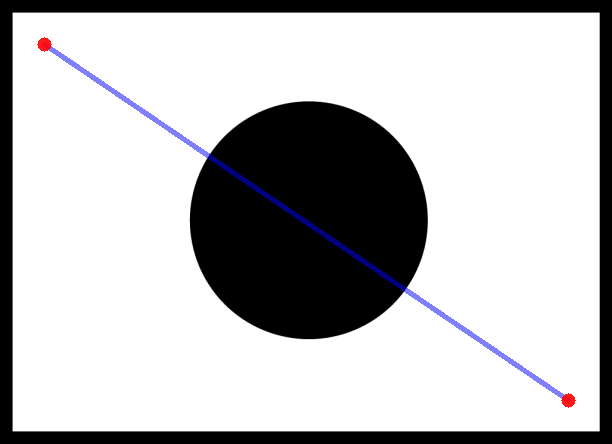

In [ ]:
c = ContinuousPlannerUtil('circle.png', scale=0.6)

c.draw_line_segment([0.1,0.1], [0.9, c.width-0.1], thickness=0.008, bgr_color=(255,0,0), alpha=0.5)
c.draw_circle([0.1, 0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)
c.draw_circle([0.9, c.width-0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)

c.show_image()

We can also output a sequence of images from our `ContinuousPlannerUtil` to make a GIF that can be viewed as an animation.  For instance, this outputs a GIF called `test.gif`.  The GIF output will play at 5 frames per second (fps), and will hold the final frame for 1 second at the end.  The GIF will be saved in the file folder in the left file popup window on the left-side of the Google Colab environment.

In [ ]:
c = ContinuousPlannerUtil('circle.png', scale=0.6)

c.save_image_to_gif_image_stack()

c.draw_line_segment([0.1,0.1], [0.9, c.width-0.1], thickness=0.008, bgr_color=(255,0,0), alpha=0.5)
c.draw_circle([0.1, 0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)
c.draw_circle([0.9, c.width-0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)

c.save_image_to_gif_image_stack()

c.draw_line_segment([0.9,0.1], [0.1, c.width-0.1], thickness=0.008, bgr_color=(255,0,0), alpha=0.5)
c.draw_circle([0.9, 0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)
c.draw_circle([0.1, c.width-0.1], radius=0.015, bgr_color=(0,0,255), alpha=0.9)

c.save_image_to_gif_image_stack()

c.output_gif_animation('test', fps=5, num_seconds_at_end=1)

test.gif has been created.  Click on the file in the files sidebar for playback.


Here are some other functions afforded by the `ContinuousPlannerUtil` that will be necessary for this assigment.

In [ ]:
c = ContinuousPlannerUtil('circle.png', scale=0.6)

# checks if state is in collision.
# This is directly in the center of the circle, so should be True.
in_collision = c.is_state_in_collision([c.height/2, c.width/2])
print('in collision 1: ', in_collision)

# checks if state is in the upper left, so should be False.
in_collision = c.is_state_in_collision([0.1, 0.1])
print('in collision 2: ', in_collision)

# checks if the straight line connection between two states is feasible.
# This is the connection between the upper left and the lower right, so should
# be False.
connection_is_feasible = c.is_straight_line_connection_feasible([0.1,0.1], [c.height-0.1, c.width-0.1])
print('connection is feasible 1: ', connection_is_feasible)

# checks if the straight line connection between two states is feasible.
# This is the connection between the upper left and the upper right, so should
# be True.
connection_is_feasible = c.is_straight_line_connection_feasible([0.1,0.1], [0.1, c.width-0.1])
print('connection is feasible 2: ', connection_is_feasible)

# This will randomly sample a state between the bounds of our image.
sampled_state = c.sample_state()
print('sampled state: ', sampled_state)


in collision 1:  True
in collision 2:  False
connection is feasible 1:  False
connection is feasible 2:  True
sampled state:  [0.12499737 0.43667306]


All of the continuous planning algorithms we will be implementing in this assignment build up some graph via ***vertices*** and ***edges***.  I provide a standard implementation of `Vertex` and `Edge`, as well as collections called `VertexList` and `EdgeList` that can hold multiple vertices and edges, respectively.  Here, I demonstrate some functions on all of these objects:

In [ ]:
# initialize a `VertexList`
vertex_list = VertexList()
# initialize an `EdgeList`
edge_list = EdgeList()

# initializes a `Vertex` with a state [0.1, 0.1].  We also
# set its bgr_color to be (255, 200, 30).  This color will be
# reflected on the vertex when it is drawn later.
vertex1 = Vertex([0.1,0.1], bgr_color=(255, 200, 30))

# we can access the state of the vertex as follows:
state = vertex1.state
print('state on vertex: ', state)
print('----')

# we can now add our vertex to the `VertexList`.  As a convenience,
# the `add_vertex` function also returns the just added vertex object
vertex1 = vertex_list.add_vertex(vertex1)

# let's now add a few vertices to our list without initializing it separately
vertex2 = vertex_list.add_vertex(Vertex([0.5, 0.1], bgr_color=(200, 255, 30)))
vertex3 = vertex_list.add_vertex(Vertex([0.7, 0.3], bgr_color=(100, 30, 255)))
vertex4 = vertex_list.add_vertex(Vertex([0.1, 0.52], bgr_color=(50, 255, 90)))

# we can get the number of vertices in the vertex list
num_vertices = len(vertex_list.vertices)
print('number of vertices: ', num_vertices)
print('---')

# the vertex list class has several useful functions.  For instance, we can
# get the closest vertex to the given state.  Note that this function returns
# the closest vertex and thet distance
(closest_vertex, distance) = vertex_list.get_closest_vertex_in_graph([0.11, 0.11])
print('closest vertex: ', closest_vertex.state, ', distance: ', distance)
print('----')

# we can also get the closest n vertices to a given state.  Note that the returned
# list contains tuple elements of (vertex, distance)
closest_n_vertices = vertex_list.get_n_closest_vertices_in_graph_in_sorted_order([0.11, 0.11], 3)
for (i, (vertex, distance)) in enumerate(closest_n_vertices):
  print('closest vertex ', i+1, ': ', vertex.state, ', distance: ', distance)
print('---')

# we can also get all vertices within some raidus of a given state. Note that
# the returned list contains tuple elements of (vertex, distance)
vertices_within_radius_r = vertex_list.get_graph_vertices_within_distance_r([0.11, 0.11], 0.4, sorted=True)
for (i, (vertex, distance)) in enumerate(vertices_within_radius_r):
  print('vertex within radius ', i+1, ': ', vertex.state, ', distance: ', distance)
print('---')

# we can also create edges between vertices.  For instance, this is an edge
# connection between vertex1 and vertex2
edge = Edge(vertex1, vertex2)

# we can access information from the edge like so
print('first vertex on edge: ', edge.vertex_1.state)
print('second vertex on edge: ', edge.vertex_2.state)
edge_length = edge.length
print('edge length: ', edge_length)
print('---')

# vertex 1 and vertex 2 now also have information about this edge.
# For instance, vertex 1 will save this edge as an outgoing edge, and
# vertex 2 will save this edge as its incoming edge.
# note that the edge references are the same between the two vertices.
print('vertex 1 outgoing edges: ', vertex1.outgoing_edges)
print('vertex 2 incoming edges: ', vertex2.incoming_edges)
print('---')

# let's now add this edge to our edge list.  As a convenience, this function
# returns the just added edge object
added_edge = edge_list.add_edge(edge)

# let's now add an edge to the `EdgeList` without separately initializing it.
added_edge = edge_list.add_edge(Edge(vertex3, vertex4))

# we can also delete an edge using its start and end vertices.  For instance,
# the following will delete the first edge that we created
edge_list.delete_edge(vertex1, vertex2)

# note that if we now check the outgoing edges from vertex 1 and the incoming
# edges from vertex2, they are now empty.
print('vertex 1 outgoing edges (after deleting edge): ', vertex1.outgoing_edges)
print('vertex 2 incoming edges (after deleting edge): ', vertex2.incoming_edges)
print('---')

state on vertex:  [0.1 0.1]
----
number of vertices:  4
---
closest vertex:  [0.1 0.1] , distance:  0.014142135623730944
----
closest vertex  1 :  [0.1 0.1] , distance:  0.014142135623730944
closest vertex  2 :  [0.5 0.1] , distance:  0.3901281840626232
closest vertex  3 :  [0.1  0.52] , distance:  0.4101219330881976
---
vertex within radius  1 :  [0.1 0.1] , distance:  0.014142135623730944
vertex within radius  2 :  [0.5 0.1] , distance:  0.3901281840626232
---
first vertex on edge:  [0.1 0.1]
second vertex on edge:  [0.5 0.1]
edge length:  0.4
---
vertex 1 outgoing edges:  [<__main__.Edge object at 0x7832f383c7c0>]
vertex 2 incoming edges:  [<__main__.Edge object at 0x7832f383c7c0>]
---
vertex 1 outgoing edges (after deleting edge):  []
vertex 2 incoming edges (after deleting edge):  []
---


We can now combine the functionalities of the `ContinuousPlannerUtil`, `VertexList`, and `EdgeList`.  The `ContinousPlannerUtil` object has a built in function that can automatically draw all vertices and edges from a `VertexList` and `EdgeList` onto its image.  The following example shows how to save an output GIF called `test2.gif` using a `VertexList` and `EdgeList`.  Note that the `clear_draw_img` argument is `True` by default; this will clear the drawing canvas before drawing the vertices and edges.  This parameter can be set to `False` if need be.


In [ ]:
c = ContinuousPlannerUtil('circle.png', scale=0.6)
c.save_image_to_gif_image_stack()

vertex_list = VertexList()
edge_list = EdgeList()

vertex1 = vertex_list.add_vertex(Vertex([0.1,0.1], bgr_color=(255, 200, 30)))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

vertex2 = vertex_list.add_vertex(Vertex([0.5, 0.1], bgr_color=(200, 255, 30)))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

vertex3 = vertex_list.add_vertex(Vertex([0.7, 0.3], bgr_color=(100, 30, 255)))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

vertex4 = vertex_list.add_vertex(Vertex([0.1, 0.52], bgr_color=(50, 255, 90)))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

edge_list.add_edge(Edge(vertex1, vertex2))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

edge_list.add_edge(Edge(vertex3, vertex4))
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

edge_list.delete_edge(vertex1, vertex2)
c.draw_vertices_and_edges(vertex_list, edge_list, clear_draw_img=True)
c.save_image_to_gif_image_stack()

c.output_gif_animation('test2', fps=3, num_seconds_at_end=1)

test2.gif has been created.  Click on the file in the files sidebar for playback.


## Problems

### Problem 1

Write a program using the following starter code snippets to find a path from start state [0.5, 0.1] to goal state [0.5, 1.278] using the PRM algorithm.  The output of this program will be a GIF called `prm.gif` at 30fps. Please use the following conventions:  

- The learning phase should go through 150 main loops.  This is already in the starter code, do not change this.
- The learning phase should use a neighborhood radius `r` of 0.3.
- Please save one image to the GIF stack at the end of each learning phase loop to show the roadmap being incrementally built up.
- The query phase should use A* (with L2 distance heuristic) to find the final solution path.
- The last frame of the GIF should draw the final solution path as lines with width 0.02, color (183, 21, 212), and opacity 0f 0.5.  
- All standard vertices should be colored (255, 200, 30)
- The start and goal vertices should be colored (200, 255, 30)
- At the end of the program, print the length of the final path.

**MAJOR HINT: Because the `Edge` class only handles directed edges, undirected edges (like those used in PRM) should be mimicked via two directed edges (i.e., an undirected edge between a and b can be mimicked by a direct edge from a to b and a direct edge from b to a).**

*(Expected running time on this program is about 2 seconds)*

In [ ]:
np.random.seed(441956) # DO NOT CHANGE THIS

def prm_learning_phase(c):
  vertex_list = VertexList() # DO NOT CHANGE THIS
  edge_list = EdgeList() # DO NOT CHANGE THIS

  for i in range(150):
    sample = c.sample_state()
    # your code will go here #######################

    ################################################

  return (vertex_list, edge_list) # DO NOT CHANGE THIS

def prm_query_phase(c, vertex_list, edge_list):
  # your code will go here #######################
  # do not forget to draw solution path and print
  # the final length of the solution path at the
  # end of the query phase!
  pass # (delete this pass when you start writing your own code)

  ################################################

# DO NOT CHANGE THIS #############################
def prm(c):
  (vertex_list, edge_list) = prm_learning_phase(c)
  prm_query_phase(c, vertex_list, edge_list)
##################################################


# DO NOT CHANGE THIS #############################
if __name__ == '__main__':
  c = ContinuousPlannerUtil('circle.png', scale=0.6)
  prm(c)
  c.output_gif_animation('prm', fps=30, num_seconds_at_end=2)
##################################################

could not output prm.gif because the image stack was empty.


### Problem 2

Write a program using the following starter code snippets to find a path from start state [0.5, 0.1] to goal state [0.5, 1.278] using the RRT algorithm. The output of this program will be a GIF called rrt.gif at 30fps. Please use the following conventions:

- The step size in the algorithm should be 0.025
- The goal radius should be 0.025
- The goal bias should be 0.2.  Please use `np.random.random()` to sample a value between 0 and 1.
- Please save one image to the GIF stack each time a vertex is added to the tree.
- The last frame of the GIF should draw the final solution path as lines with width 0.02, color (183, 21, 212), and opacity 0f 0.5.
- All standard vertices should be colored (255, 200, 30)
The start and goal vertices should be colored (200, 255, 30)
- At the end of the program, print the length of the final path.

*(Expected running time on this program is about 3 seconds)*

In [ ]:
np.random.seed(441956) # DO NOT CHANGE THIS

def rrt(c):
  vertex_list = VertexList() # DO NOT CHANGE THIS
  edge_list = EdgeList() # DO NOT CHANGE THIS

  # your code will go here #######################


  ################################################


# DO NOT CHANGE THIS #############################
if __name__ == '__main__':
  c = ContinuousPlannerUtil('circle.png', scale=0.6)
  rrt(c)
  c.output_gif_animation('rrt', fps=30, num_seconds_at_end=2)
##################################################

could not output rrt.gif because the image stack was empty.


### Problem 3

Write a program using the following starter code snippets to find a path from start state [0.5, 0.1] to goal state [0.5, 1.278] using the RRT-Connect algorithm. The output of this program will be a GIF called rrt_connect.gif at 30fps. Please use the following conventions:

- The step size in the algorithm should be 0.025
- The goal radius should be 0.025
- When picking which tree to expand next, always pick the smaller tree in terms of number of nodes.  In the case of a tie, pick the tree rooted at the start node.
- Please save one image to the GIF stack each time a vertex is added to the tree.
- The last frame of the GIF should draw the final solution path as lines with width 0.02, color (183, 21, 212), and opacity 0f 0.5.
- All standard vertices in the tree rooted at the start should be colored (255, 200, 30).  All standard vertices in the tree rooted at the goal should be colored (200, 255, 30)
- At the end of the program, print the length of the final path.

*(Expected running time on this program is about 3 seconds)*

In [ ]:
np.random.seed(1234) # DO NOT CHANGE THIS

def rrt_connect(c):
  V1 = VertexList() # DO NOT CHANGE THIS
  V1.add_vertex(Vertex([0.5, 0.1], bgr_color=(255, 200, 30))) # DO NOT CHANGE THIS
  E1 = EdgeList() # DO NOT CHANGE THIS

  V2 = VertexList() # DO NOT CHANGE THIS
  V2.add_vertex(Vertex([0.5, 1.278], bgr_color=(200, 255, 30))) # DO NOT CHANGE THIS
  E2 = EdgeList() # DO NOT CHANGE THIS

  # your code will go here #######################


  ################################################

# DO NOT CHANGE THIS #############################
if __name__ == '__main__':
  c = ContinuousPlannerUtil('circle.png', scale=0.6)
  rrt_connect(c)
  c.output_gif_animation('rrt_connect', fps=30, num_seconds_at_end=2)
##################################################

could not output rrt_connect.gif because the image stack was empty.


### Problem 4

Write a program using the following starter code snippets to find a path from start state [0.5, 0.1] to goal state [0.5, 1.278] using the RRT* algorithm. The output of this program will be a GIF called rrt_star.gif at 30fps. Please use the following conventions:

- The step size in the algorithm should be 0.025
- The goal radius should be 0.025
- The neighborhood radius should be 0.05
- The goal bias should be 0.2. Please use np.random.random() to sample a value between 0 and 1.
- Please save one image to the GIF stack each time a vertex is added to the tree and after each rewiring phase.
- Run RRT* for 5000 loops.
- Once an initial solution is found, draw the solution path as lines with width 0.02, color (183, 21, 212), and opacity 0f 0.5.  This solution path should improve in quality over time.  Remember that drawing vertices and edges using the default `draw_vertices_and_edges` function clears the canvas, so drawing the solution path should happen *after* the call to this function.
- Once an initial solution path is found, check after each loop to see if the solution has improved in terms of cost (shorter path from start to goal).  If it did, print the improved cost to the console.  The final output in the console should be the best cost found in the 5000 loops.   
- All standard vertices should be colored (255, 200, 30) The start and goal vertices should be colored (200, 255, 30)

*(Expected running time on this program is about four minutes.  It would probably be a good idea to test and debug with fewer loops)*

In [ ]:
np.random.seed(441956) # DO NOT CHANGE THIS

def rrt_star(c):
  vertex_list = VertexList() # DO NOT CHANGE THIS
  edge_list = EdgeList() # DO NOT CHANGE THIS

  # your code will go here #######################

  ################################################

# DO NOT CHANGE THIS #############################
if __name__ == '__main__':
  c = ContinuousPlannerUtil('circle.png', scale=0.6)
  rrt_star(c)
  c.output_gif_animation('rrt_star', fps=100, num_seconds_at_end=2)
##################################################

could not output rrt_star.gif because the image stack was empty.
